In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, Math, Latex
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
InteractiveShell.ast_node_interactivity = "all"

from models.pv_model import PVModel
from models.load import Consumer, hour_loads
from models.storage import StorageModel

%matplotlib inline

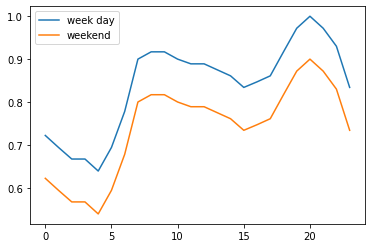

In [2]:
plt.plot(hour_loads.keys(), hour_loads.values());
plt.plot(hour_loads.keys(), np.array(list(hour_loads.values()))-0.1);
plt.legend(['week day', 'weekend']);

In [3]:
unit_cons_load = pd.DataFrame()

unit_cons_load['appliance'] = ['light bulb', 
                               'computer',
                               'laptop',
                               'television',
                               'phone charger',
                               'fridge',
                               'washing machine']
unit_cons_load['quantity'] = [5, 1, 1, 1, 2, 1, 1]
unit_cons_load['hours_per_day'] = [6, 10, 10, 10, 4, 3, 3]
unit_cons_load['power_rating'] = [20, 250, 40, 30, 5, 150, 125]
unit_cons_load[
    'total_per_day'] = unit_cons_load.hours_per_day*unit_cons_load.quantity*unit_cons_load.power_rating

unit_cons_load

,appliance,quantity,hours_per_day,power_rating,total_per_day
0,light bulb,5,6,20,600
1,computer,1,10,250,2500
2,laptop,1,10,40,400
3,television,1,10,30,300
4,phone charger,2,4,5,40
5,fridge,1,3,150,450
6,washing machine,1,3,125,375


### Daily household load (Wh)

In [4]:
np.sum(unit_cons_load['total_per_day'])

4665

### Daily 100 households load (kWh)

In [5]:
np.sum(unit_cons_load['total_per_day'])*100/1000

466.5

### Hourly 100 households load, rough estimate (kWh)

In [6]:
h_load = (np.sum(unit_cons_load.hours_per_day*unit_cons_load.quantity*unit_cons_load.power_rating)*100/1000)/24
p_load = h_load
h_load

19.4375

### Storage system capacity

In [7]:
display(Math(r'C_b = \frac{ W_d * T_{out}}{\eta_{b} * DoD }'))

<IPython.core.display.Math object>

In [8]:
consumer = Consumer()

In [9]:
eta_r = 0.19
eta_tr = 0.25
NOCT = 45

module_area = (156*156)/1000
battery_capacity = 160e3

n_panels = [400, 425, 450, 475, 500, 525, 550]

In [10]:
df = pd.read_csv('solar_rad.csv')
df_de = pd.read_csv('solar_rad_de.csv')
df.loc[:, 'time'] = pd.to_datetime(df.time)
df_de.loc[:, 'time'] = pd.to_datetime(df_de.time)
df.head()

,time,temperature,global_radiation
0,2005-01-01 06:10:00,0.90,13.63
1,2005-01-01 07:10:00,1.42,81.08
2,2005-01-01 08:10:00,1.95,60.02
3,2005-01-02 06:10:00,0.92,13.59
4,2005-01-02 07:10:00,1.68,186.08


In [11]:
df.tail()

,time,temperature,global_radiation
39035,2016-12-31 09:10:00,-0.42,914.28
39036,2016-12-31 10:10:00,0.05,815.20
39037,2016-12-31 11:10:00,0.52,643.91
39038,2016-12-31 12:10:00,0.98,822.75
39039,2016-12-31 13:10:00,-1.04,493.15


In [12]:
df = df.iloc[::10, :] # scale down for now
df_de = df_de.iloc[::10, :]

In [14]:
ref_temp = df.temperature.values[0]
module_nums = []
en_surplus = []
en_deficit = []
res_df = pd.DataFrame()

if not os.path.exists('res_df.csv'):
    for num in n_panels:
        battery = StorageModel()
        model = PVModel(num*60, module_area) # 1 panel = 60 modules
        for idx, row in tqdm(df.iterrows()):
            hour = row.time.hour
            temperature, radiation = row.temperature, row.global_radiation

            state = model.calc_state(radiation, temperature, ref_temp)
            load = consumer.load_grid(hour)
            ref_temp = temperature

            stored = battery.process_load(load*1000)
            module_nums.append(num)

            en_surplus.append((num, stored, state-load*1000))

            record = {
                'date': row.time,
                'load': load,
                'n_panels': num,
                'battery_energy': stored,
                'temperature': ref_temp,
                'radiation': radiation,
                'state': state,
            }

            res_df = res_df.append(record, ignore_index=True)
else:
    res_df = pd.read_csv('res_df.csv')

In [17]:
res_df

,battery_energy,date,load,n_modules,radiation,state,temperature
0,307.2,2005-01-01 06:10:00,248.380062,400.0,13.63,1.553820e+04,0.90
1,307.2,2005-01-04 09:10:00,90.094091,400.0,863.89,9.795657e+05,1.97
2,307.2,2005-01-06 08:10:00,395.644382,400.0,745.52,8.376543e+05,4.85
3,307.2,2005-01-08 06:10:00,183.870695,400.0,12.93,1.480432e+04,3.98
4,307.2,2005-01-09 10:10:00,186.070988,400.0,926.09,1.033994e+06,8.10
...,...,...,...,...,...,...,...
27323,307.2,2016-12-23 11:10:00,660.467190,550.0,782.31,1.218545e+06,1.60
27324,307.2,2016-12-26 07:10:00,575.987563,550.0,234.95,3.720222e+05,-0.43
27325,307.2,2016-12-28 07:10:00,280.700028,550.0,611.09,9.468679e+05,1.87
27326,307.2,2016-12-29 09:10:00,469.542027,550.0,798.98,1.252151e+06,1.91


In [18]:
vis_df = res_df[res_df.n_panels == 500]
vis_df = vis_df[vis_df.index%50 == 0]

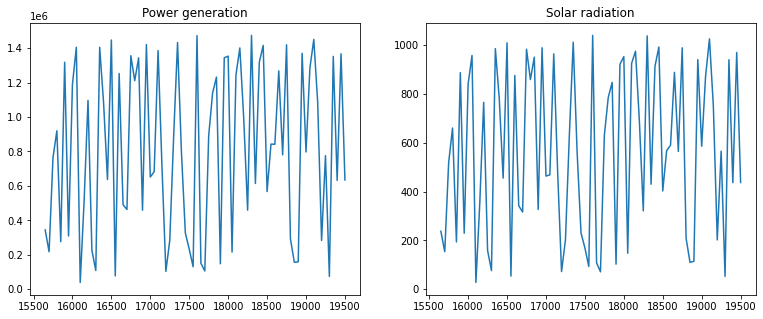

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
vis_df.state.plot(ax=ax[0]);
ax[0].set_title('Power generation');
vis_df.radiation.plot(ax=ax[1]);
ax[1].set_title('Solar radiation');

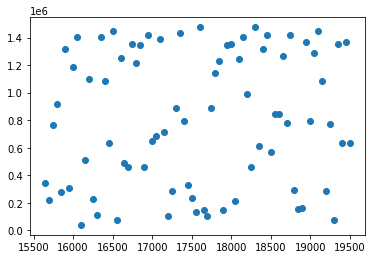

In [20]:
plt.scatter(vis_df.index, vis_df.state)

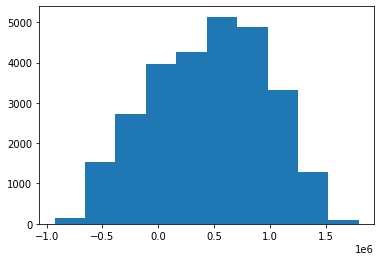

In [21]:
plt.hist([x[2] for x in en_surplus]);

In [22]:
module_nums = np.array(module_nums)

In [24]:
np.quantile(module_nums, 0.75)

525.0

In [25]:
len(en_surplus), len(en_deficit)

(27328, 0)

In [26]:
candidates = [425,  450,  475,  500,  525,  550]

print('Surplus')
for cand in candidates:
    print(f'{cand} panels: {np.mean([x[-1] for x in en_surplus if x[0]==cand])} mean surplus')
    print(f'{cand} panels: {np.median([x[-1] for x in en_surplus if x[0]==cand])} median surplus')
    print(f'{cand} panels: {np.std([x[-1] for x in en_surplus if x[0]==cand])} standard deviation surplus')
    print('-'*10)

print('Deficit')
for cand in candidates:
    print(f'{cand} panels: {np.mean([x[-1] for x in en_deficit if x[0]==cand])} mean surplus')
    print(f'{cand} panels: {np.median([x[-1] for x in en_deficit if x[0]==cand])} median surplus')
    print(f'{cand} panels: {np.std([x[-1] for x in en_deficit if x[0]==cand])} standard deviation surplus')
    print('-'*10)

Surplus
425 modules: 370299.1008651342 mean surplus
425 modules: 404859.83950917586 median surplus
425 modules: 465432.7651816363 standard deviation surplus
----------
450 modules: 414725.38512130064 mean surplus
450 modules: 461224.11673138407 median surplus
450 modules: 485407.89746843895 standard deviation surplus
----------
475 modules: 458541.5628201681 mean surplus
475 modules: 514009.8560636786 median surplus
475 modules: 500569.2831580332 standard deviation surplus
----------
500 modules: 499197.87761521916 mean surplus
500 modules: 558303.869088883 median surplus
500 modules: 523200.2752563113 standard deviation surplus
----------
525 modules: 539679.7709690252 mean surplus
525 modules: 607982.5092254217 median surplus
525 modules: 539621.7299755615 standard deviation surplus
----------
550 modules: 577088.9209308682 mean surplus
550 modules: 647495.6762652942 median surplus
550 modules: 568825.8832623996 standard deviation surplus
----------
Deficit
425 modules: nan mean surp

/home/val/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/val/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/val/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/val/.local/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/val/.local/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


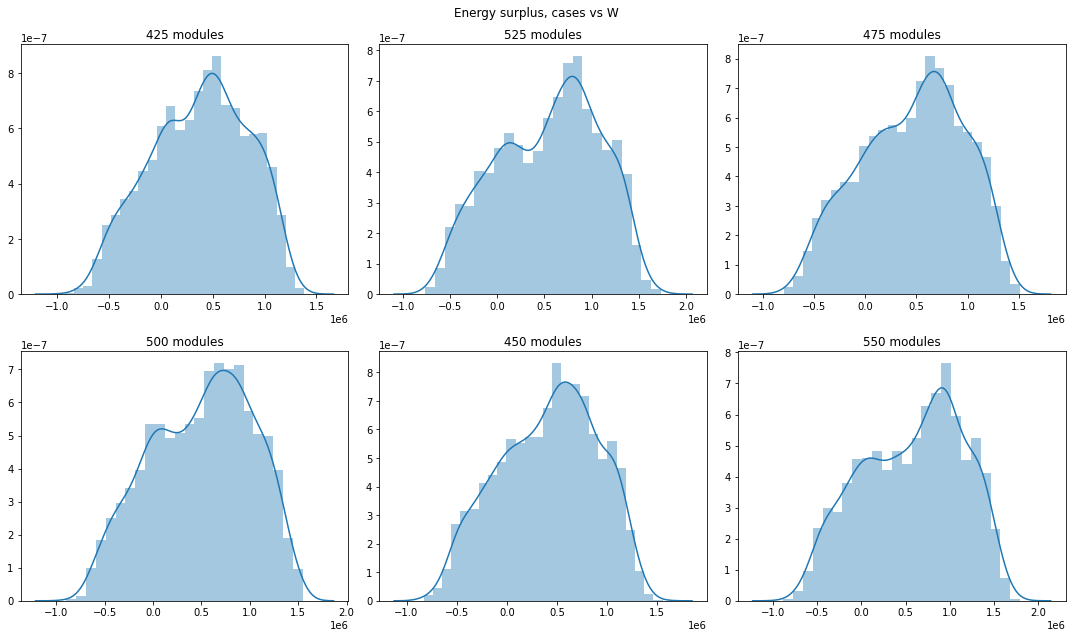

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i, cand in enumerate(candidates):
    sns.distplot(np.array(([x[-1] for x in en_surplus if x[0]==cand])), ax=ax[i%2][i%3]);
    ax[i%2][i%3].set_title(f'{cand} panels');

fig.suptitle('Energy surplus, cases vs W');
plt.tight_layout();

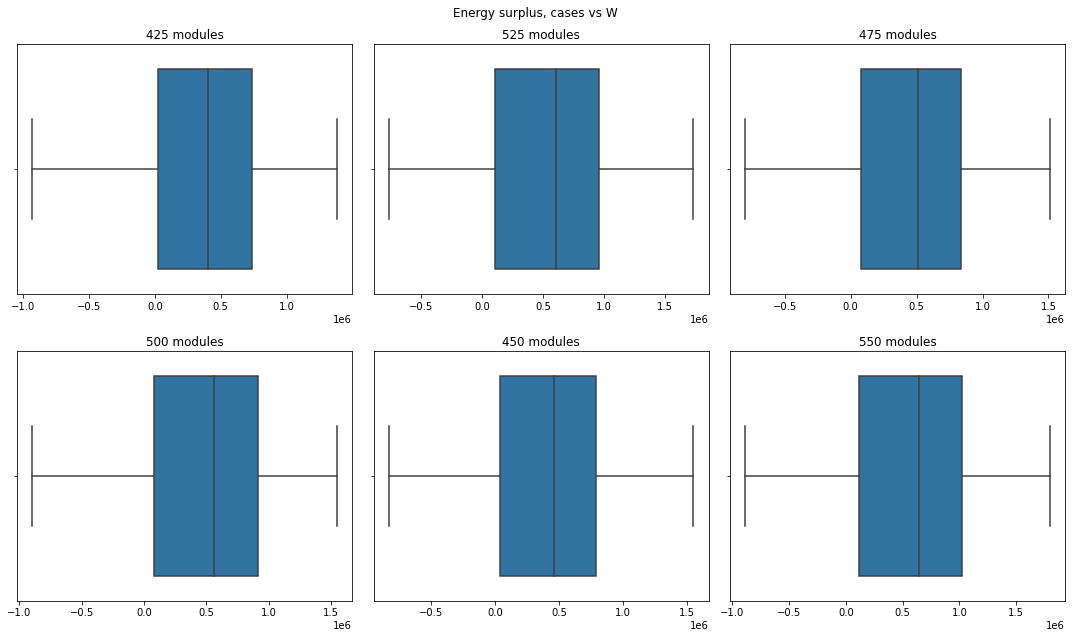

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i, cand in enumerate(candidates):
    sns.boxplot(np.array(([x[-1] for x in en_surplus if x[0]==cand])), ax=ax[i%2][i%3]);
    ax[i%2][i%3].set_title(f'{cand} panels');

fig.suptitle('Energy surplus, cases vs W');
plt.tight_layout();

In [29]:
len(en_surplus), len(en_deficit)

(27328, 0)

In [30]:
len([x for x in en_surplus if x[1]>0]), len([x for x in en_deficit if x[1]<=battery_capacity*0.25])

(27328, 0)

In [31]:
np.sum([x for x in en_surplus if x[1]>0])/1e7, np.sum([x for x in en_deficit if x[1]<=battery_capacity*0.25])/1e7

(1244.64856216305, 0.0)

In [32]:
n_mods = 500
en_sup_mods = [x for x in en_surplus if x[0]==n_mods]
en_def_mods = [x for x in en_deficit if x[0]==n_mods]
np.sum([x for x in en_sup_mods if x[1]>0])/1e7, np.sum(
    [x for x in en_def_mods if x[1]<=battery_capacity*0.25])/1e7

(195.19653462098157, 0.0)

In [33]:
p_load*1000

19437.5

In [34]:
len(en_sup_mods)/(len(en_sup_mods)+len(en_def_mods))

1.0

In [35]:
len(en_sup_mods)+len(en_def_mods)

3904

In [36]:
len(en_sup_mods)

3904

### Ukraine vs Germany

In [41]:
n_panels = [500]
dfs = []

for dataframe in [df, df_de]:
    ref_temp = dataframe.temperature.values[0]
    res_dataframe = pd.DataFrame()
    en_surplus = []
    en_deficit = []
    
    for num in n_panels:
        battery = StorageModel()
        model = PVModel(num*60, module_area) # 1 panel = 60 modules
        for idx, row in tqdm(dataframe.iterrows(),
                             total=dataframe.shape[0]):
            hour = row.time.hour
            temperature, radiation = row.temperature, row.global_radiation

            state = model.calc_state(radiation, temperature, ref_temp)
            load = consumer.load_grid(hour)
            ref_temp = temperature

            stored = battery.process_load(load*1000)

            en_surplus.append((num, stored, state-load*1000))

            record = {
                'date': row.time,
                'load': load,
                'n_panels': num,
                'battery_energy': stored,
                'temperature': ref_temp,
                'radiation': radiation,
                'state': state,
            }

            res_dataframe = res_dataframe.append(record, ignore_index=True)
    dfs.append(res_dataframe)

In [42]:
dfs[1]

,battery_energy,date,load,n_panels,radiation,state,temperature
0,307.2,2005-01-01 09:10:00,582.436407,500.0,62.680001,8.931900e+04,6.25
1,307.2,2005-01-05 09:10:00,766.822857,500.0,71.049999,1.018892e+05,4.98
2,307.2,2005-01-08 10:10:00,549.411111,500.0,794.879973,1.102064e+06,10.39
3,307.2,2005-01-09 14:10:00,486.805160,500.0,746.649988,1.082277e+06,6.95
4,307.2,2005-01-13 08:10:00,397.634648,500.0,223.039993,3.220750e+05,4.28
...,...,...,...,...,...,...,...
3633,307.2,2016-12-23 10:10:00,195.898130,500.0,81.330000,1.148696e+05,2.42
3634,307.2,2016-12-24 13:10:00,884.750083,500.0,356.319998,4.999619e+05,5.49
3635,307.2,2016-12-27 09:10:00,667.964323,500.0,40.160000,5.741113e+04,4.85
3636,307.2,2016-12-29 13:10:00,469.684082,500.0,66.540000,9.536945e+04,3.69


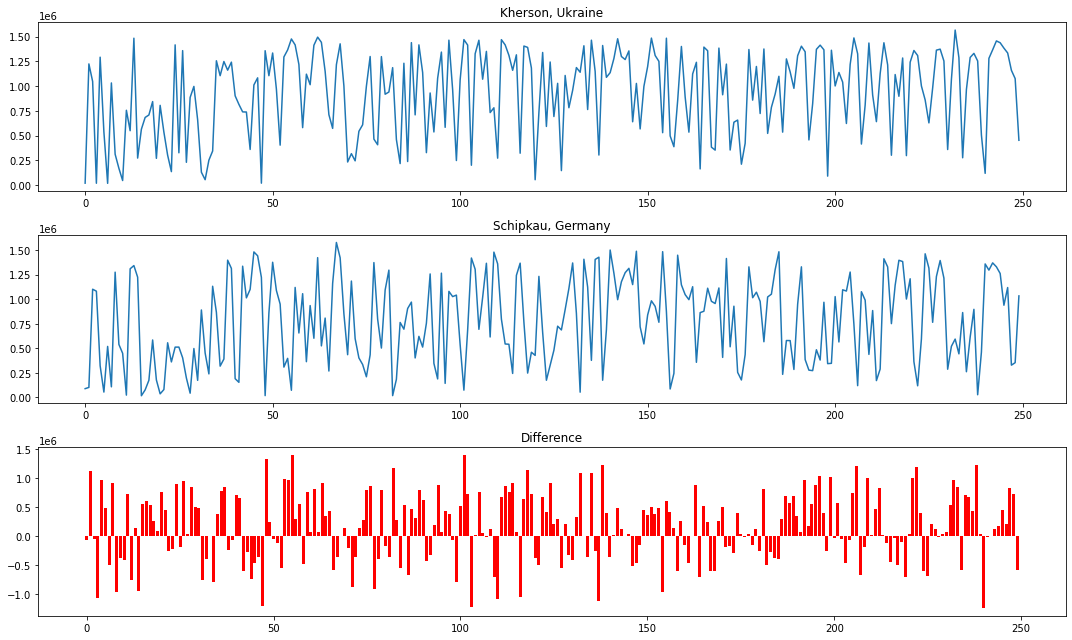

In [46]:
sample_size = 250
fig, ax = plt.subplots(3,1, figsize=(15, 9))
residuals = dfs[0][:sample_size].state - dfs[1][:sample_size].state

ax[0].plot(dfs[0][:sample_size].state);
ax[0].set_title('Kherson, Ukraine');
ax[1].plot(dfs[1][:sample_size].state);
ax[1].set_title('Schipkau, Germany');
ax[2].bar(dfs[0][:sample_size].index, residuals, color='red');
ax[2].set_title('Difference');
plt.tight_layout();
plt.savefig('fig123.png');

In [47]:
residuals.mean()

151321.89134962816